### Introduction
Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

### Problem Statement
Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

In [5]:
!pip install missingno

In [6]:
!pip install tensorflow

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
w.filterwarnings('ignore')
import missingno as msno
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [8]:
# !gdown --id 1kkgBGldeswHBgVKEJiqqG7VZvqZNMc-5 -O /content/dataset.csv

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
data = pd.read_csv('dataset.csv')

### Data Dictionary

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.

* **market_id :** integer id for the market where the restaurant lies
* **created_at :** the timestamp at which the order was placed
* **actual_delivery_time :** the timestamp when the order was delivered
* **store_primary_category :** category for the restaurant
* **order_protocol :** integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
* **total_items subtotal :** final price of the order
* **num_distinct_items :** the number of distinct items in the order
* **min_item_price :** price of the cheapest item in the order
* **max_item_price :** price of the costliest item in order
* **total_onshift_partners :** number of delivery partners on duty at the time order was placed
* **total_busy_partners :** number of delivery partners attending to other tasks
* **total_outstanding_orders :** total number of orders to be fulfilled at the moment

In [11]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174260 entries, 0 to 174259
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 173376 non-null  float64
 1   created_at                174260 non-null  object 
 2   actual_delivery_time      174253 non-null  object 
 3   store_id                  174260 non-null  object 
 4   store_primary_category    170060 non-null  object 
 5   order_protocol            173371 non-null  float64
 6   total_items               174260 non-null  int64  
 7   subtotal                  174260 non-null  int64  
 8   num_distinct_items        174260 non-null  int64  
 9   min_item_price            174260 non-null  int64  
 10  max_item_price            174260 non-null  int64  
 11  total_onshift_partners    159988 non-null  float64
 12  total_busy_partners       159988 non-null  float64
 13  total_outstanding_orders  159988 non-null  f

### Inference
* Need to change datatype from **object to datetime** for columns **created_at and actual_delivery_time**
* Need to investigate few columns are **market_id, order_protocol, total_onshift_partners, total_busy_partners and total_outstanding_orders** as it shows datatype is float, and it should be int *(The one reason could be, having null values in these columns as null values in column shows float datatype )*

In [13]:
data.shape

(174260, 14)

In [14]:
#### calculate null percentage
data.isna().sum()


,0
market_id,884
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,4200
order_protocol,889
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


#### Inference :
* **total_onshift_partners, total_busy_partners and total_outstanding_orders** these columns having **equal number of missing data**. may be these columns are realed to each other
* Another columns **market_id,  store_primary_category, order_protocol** having missing data
* Need to check **market_id** is unique or not and find the kind of missingness.
* Need to change datatype for columns **created_at and actual_delivery_time**

In [15]:
data.nunique()

,0
market_id,6
created_at,161343
actual_delivery_time,158918
store_id,5981
store_primary_category,74
order_protocol,7
total_items,53
subtotal,8150
num_distinct_items,20
min_item_price,2254


#### Inference :
* Dataset doesn't have a column that holds all unique values.
* Some orders are created at same time. Need to check orders whose having same created time and delivery time as actual delivery time is same for few orders

  

In [16]:
data['market_id'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [17]:
data['order_protocol'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.,  7.])

In [18]:
data['num_distinct_items'].unique()


array([ 4,  1,  5,  3,  2,  6,  7,  8, 10, 14,  9, 11, 12, 13, 15, 20, 18,
       16, 17, 19])

In [19]:
data['num_distinct_items'].value_counts()

,count
num_distinct_items,
2,52236
1,43739
3,36932
4,20587
5,10463
6,5032
7,2584
8,1280
9,645


In [20]:
data.duplicated().sum()

np.int64(0)

#### Inference
* Dataset doesn't hold duplicate entries
* Porter deliver items from 6 markets and follows 7 protocols for ordering items.
* There are few **outliers** in column **num_distinct_items** as only few customers are ordering  above 15 food items.

### Data Preprocessing

#### change datatype for columns "created_at" and "actual_delivery_time" to pandas datetime

In [21]:

data["actual_delivery_time"] = pd.to_datetime(data["actual_delivery_time"])
data["created_at"]=pd.to_datetime(data["created_at"])

In [22]:
data["hour"] = data["created_at"].dt.hour
data["day"] = data["created_at"].dt.dayofweek
data["year"] = data["created_at"].dt.year
data["month"] = data["created_at"].dt.month
data["time"] = data["created_at"].dt.time
data["day_name"] = data["created_at"].dt.day_name()

In [23]:
data["delivery_hour"] = data["actual_delivery_time"].dt.hour
data["delivery_day"] = data["actual_delivery_time"].dt.dayofweek
data["delivery_year"] = data["actual_delivery_time"].dt.year
data["delivery_month"] = data["actual_delivery_time"].dt.month
data["delivery_time"] = data["actual_delivery_time"].dt.time
data["delivery_day_name"] = data["actual_delivery_time"].dt.day_name()

#### Created Output feature

In [24]:
data["total_time"] = data["actual_delivery_time"] - data["created_at"]
# Convert the timedelta to minutes
data["total_time"] = (pd.to_timedelta(data['total_time']).dt.total_seconds() // 60)

In [25]:
data.sample(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
76574,2.0,2015-02-11 21:00:58,2015-02-11 21:42:02,2cfa8f9e50e0f510ede9d12338a5f564,chinese,1.0,1,675,1,675,675,51.0,52.0,78.0,21,2,2015,2,21:00:58,Wednesday,21.0,2.0,2015.0,2.0,21:42:02,Wednesday,41.0
106760,6.0,2015-02-12 04:19:43,2015-02-12 05:10:31,2fe37bd25993870f5a38563dd25b1d05,american,4.0,2,1700,2,800,900,NaN,NaN,NaN,4,3,2015,2,04:19:43,Thursday,5.0,3.0,2015.0,2.0,05:10:31,Thursday,50.0
87055,1.0,2015-02-09 00:48:02,2015-02-09 01:17:32,0e55666a4ad822e0e34299df3591d979,thai,1.0,4,2850,4,200,1250,35.0,36.0,40.0,0,0,2015,2,00:48:02,Monday,1.0,0.0,2015.0,2.0,01:17:32,Monday,29.0
151247,5.0,2015-02-04 20:34:30,2015-02-04 21:07:13,314e9197a43a6d40cef6f1629e2c3721,NaN,5.0,3,825,1,275,275,23.0,22.0,24.0,20,2,2015,2,20:34:30,Wednesday,21.0,2.0,2015.0,2.0,21:07:13,Wednesday,32.0
12916,4.0,2015-02-10 04:59:22,2015-02-10 05:31:29,eae27d77ca20db309e056e3d2dcd7d69,thai,5.0,5,2975,4,295,1095,40.0,34.0,39.0,4,1,2015,2,04:59:22,Tuesday,5.0,1.0,2015.0,2.0,05:31:29,Tuesday,32.0


In [26]:
data.sample(30)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
123400,4.0,2015-02-11 17:26:38,2015-02-11 17:55:39,fc49306d97602c8ed1be1dfbf0835ead,american,4.0,2,2198,2,1099,1099,6.0,5.0,5.0,17,2,2015,2,17:26:38,Wednesday,17.0,2.0,2015.0,2.0,17:55:39,Wednesday,29.0
91094,2.0,2015-02-14 18:47:02,2015-02-14 19:20:31,c31e46a74fb556fd7b53f8f6b186d5e9,mexican,5.0,2,1498,2,499,799,16.0,15.0,13.0,18,5,2015,2,18:47:02,Saturday,19.0,5.0,2015.0,2.0,19:20:31,Saturday,33.0
155063,2.0,2015-02-09 02:02:43,2015-02-09 03:08:26,dc0e16a46c7bb604bc7fd87037f32787,pizza,2.0,4,2996,3,499,999,131.0,74.0,153.0,2,0,2015,2,02:02:43,Monday,3.0,0.0,2015.0,2.0,03:08:26,Monday,65.0
90713,4.0,2015-01-31 03:25:46,2015-01-31 04:28:26,5a7f963e5e0504740c3a6b10bb6d4fa5,chinese,3.0,4,3381,4,931,1320,108.0,102.0,190.0,3,5,2015,1,03:25:46,Saturday,4.0,5.0,2015.0,1.0,04:28:26,Saturday,62.0
66211,3.0,2015-02-11 00:48:37,2015-02-11 01:17:25,3445ee86ba8817378a8577a75444f5d7,sandwich,1.0,1,850,1,850,850,5.0,3.0,2.0,0,2,2015,2,00:48:37,Wednesday,1.0,2.0,2015.0,2.0,01:17:25,Wednesday,28.0
81417,2.0,2015-02-05 21:11:10,2015-02-05 21:53:56,c1502ae5a4d514baec129f72948c266e,burger,4.0,7,3441,5,279,695,52.0,57.0,74.0,21,3,2015,2,21:11:10,Thursday,21.0,3.0,2015.0,2.0,21:53:56,Thursday,42.0
84976,4.0,2015-02-04 03:38:45,2015-02-04 04:26:20,cd89fef7ffdd490db800357f47722b20,american,3.0,4,5350,4,700,1850,81.0,71.0,105.0,3,2,2015,2,03:38:45,Wednesday,4.0,2.0,2015.0,2.0,04:26:20,Wednesday,47.0
118434,3.0,2015-02-12 20:20:33,2015-02-12 21:00:58,949e6667758e0ad6d5c27933d9aa8ef3,other,3.0,3,2943,3,795,825,24.0,22.0,22.0,20,3,2015,2,20:20:33,Thursday,21.0,3.0,2015.0,2.0,21:00:58,Thursday,40.0
141218,6.0,2015-01-25 02:34:43,2015-01-25 03:33:36,7cac11e2f46ed46c339ec3d569853759,pizza,1.0,2,3450,2,500,2700,NaN,NaN,NaN,2,6,2015,1,02:34:43,Sunday,3.0,6.0,2015.0,1.0,03:33:36,Sunday,58.0
173557,5.0,2015-02-08 03:19:10,2015-02-08 03:58:37,e1054bf2d703bca1e8fe101d3ac5efcd,mexican,1.0,2,2327,2,959,1039,29.0,27.0,34.0,3,6,2015,2,03:19:10,Sunday,3.0,6.0,2015.0,2.0,03:58:37,Sunday,39.0


### Handelling missing data

#### Handle missing data for 'market_id' feature

**Strategy:**  If store_id uniquely determines market_id, then we can impute missing market_id values by looking up the market_id associated with the same store_id from non-missing rows.

#### Compare rows with and without missing market_id

In [27]:
missing_group = data[data['market_id'].isnull()]
non_missing_group = data[data['market_id'].notnull()]

# Example: compare means of numeric columns
comparison = pd.concat([
    missing_group.mean(numeric_only=True).rename('missing_market_id'),
    non_missing_group.mean(numeric_only=True).rename('non_missing_market_id')
], axis=1)

print(comparison)

                          missing_market_id  non_missing_market_id
market_id                               NaN               2.986296
order_protocol                     2.962054               2.853889
total_items                        3.208145               3.200074
subtotal                        2670.668552            2683.684443
num_distinct_items                 2.658371               2.676962
min_item_price                   672.111991             684.116625
max_item_price                  1135.963801            1158.255779
total_onshift_partners            45.266344              44.881033
total_busy_partners               42.338983              41.823934
total_outstanding_orders          59.664649              58.175205
hour                               8.196833               8.452664
day                                3.049774               3.219581
year                            2015.000000            2014.999994
month                              1.662896               1.65

#### check whether store_id uniquely determines market_id

In [28]:
# Group by store_id and count unique market_id values for each
store_market_counts = data.groupby('store_id')['market_id'].nunique()

# Check if any store_id has more than one unique market_id
store_ids_with_multiple_market_ids = store_market_counts[store_market_counts > 1]

# Display them
print(store_ids_with_multiple_market_ids)

store_id
0004d0b59e19461ff126e3a08a814c33    3
0029f088c57ad3b6ec589f9ba4f7a057    2
002f9c8cee878b64a747a2c211da7d83    2
00430c0c1fae276c9713ab5f21167882    6
00482b9bed15a272730fcb590ffebddd    2
                                   ..
ff82db7535530637af7f8a96284b3459    3
ffb14e8b6e84eb9ad09f15443be54561    2
ffbd6cbb019a1413183c8d08f2929307    2
ffd52f3c7e12435a724a8f30fddadd9c    2
ffeabd223de0d4eacb9a3e6e53e5448d    4
Name: market_id, Length: 2597, dtype: int64


**Observation:** store_id alone doesn't uniquely determine market_id, we can check combinations of other columns (like store_primary_category, order_protocol, etc.) to see if they improve the uniqueness of market_id.

In [29]:
# See combinations that uniquely map to a single market_id
unique_mapping = (
    data.groupby(['store_id', 'store_primary_category', 'order_protocol'])['market_id']
    .nunique()
    .reset_index()
)

# Filter to only those that map to one market_id
unique_mapping = unique_mapping[unique_mapping['market_id'] == 1]
print(unique_mapping.shape)

(14511, 4)


**Observation:** There are 16,389 unique combinations of (*store_id, store_primary_category, order_protocol*) that each map to exactly one market_id. This is a very strong signal that this combination can be reliably used to impute missing market_id values.

In [30]:
## Impute Missing market_id
# Step 1: Create mapping from known values
known_mapping = (
    data.dropna(subset=['market_id'])  # Only use rows where market_id is not null
    .drop_duplicates(subset=['store_id', 'store_primary_category', 'order_protocol'])
    .set_index(['store_id', 'store_primary_category', 'order_protocol'])['market_id']
)

# Step 2: Define function to apply mapping
def impute_market_id(row):
    if pd.isna(row['market_id']):
        key = (row['store_id'], row['store_primary_category'], row['order_protocol'])
        return known_mapping.get(key, np.nan)
    return row['market_id']

data['market_id'] = data.apply(impute_market_id, axis=1)


In [31]:
data['market_id'].isna().sum()

np.int64(555)

**Observation :** Since 622 market_id values are still missing after imputing based on the (store_id, store_primary_category, order_protocol) combination, we can now fill the remaining missing values with the mode (i.e., the most frequent market_id).

In [32]:
### Fill NA values with mode
store_market_map = data.dropna(subset=['market_id']).groupby('store_id')['market_id'].agg(lambda x: x.mode().iloc[0])


In [33]:
data['market_id'] = data.apply(
    lambda row: store_market_map[row['store_id']] if pd.isna(row['market_id']) and row['store_id'] in store_market_map else row['market_id'],
    axis=1
)

In [34]:
data['market_id'].isna().sum()

np.int64(2)

In [35]:
#### Handle remaining 3 missing values with constant
data['market_id'] = data['market_id'].fillna(0)

In [36]:
data['market_id'].isna().sum()

np.int64(0)

#### Handle missing data for feature 'actual_delivery_time' -
**Stratergy** : Check how much avegare delivery time is required to delivered each food items (store_primary_category) w.r.t day of the week and time.

In [37]:
data[data["actual_delivery_time"].isna() == True]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
109,3.0,2015-02-10 21:51:54,NaT,da353f402faf6cf475d4abd1450b0882,sandwich,3.0,1,1125,1,975,975,7.0,5.0,4.0,21,1,2015,2,21:51:54,Tuesday,NaN,NaN,NaN,NaN,NaT,NaN,NaN
7670,2.0,2015-02-08 02:54:42,NaT,140f6969d5213fd0ece03148e62e461e,japanese,2.0,4,2860,3,390,690,131.0,123.0,197.0,2,6,2015,2,02:54:42,Sunday,NaN,NaN,NaN,NaN,NaT,NaN,NaN
78511,4.0,2015-02-15 02:15:45,NaT,1f0e3dad99908345f7439f8ffabdffc4,catering,1.0,9,5050,6,375,1125,91.0,75.0,167.0,2,6,2015,2,02:15:45,Sunday,NaN,NaN,NaN,NaN,NaT,NaN,NaN
115982,4.0,2015-02-16 01:52:49,NaT,b92894e4589f652dc3116cb3a8c48c08,pizza,3.0,2,2094,2,599,1195,53.0,53.0,102.0,1,0,2015,2,01:52:49,Monday,NaN,NaN,NaN,NaN,NaT,NaN,NaN
140635,2.0,2015-02-15 02:21:42,NaT,0d73a25092e5c1c9769a9f3255caa65a,dessert,1.0,3,4210,3,865,1850,123.0,91.0,176.0,2,6,2015,2,02:21:42,Sunday,NaN,NaN,NaN,NaN,NaT,NaN,NaN
158967,2.0,2015-02-01 01:21:29,NaT,faacbcd5bf1d018912c116bf2783e9a1,mexican,5.0,5,3447,3,225,1349,90.0,88.0,109.0,1,6,2015,2,01:21:29,Sunday,NaN,NaN,NaN,NaN,NaT,NaN,NaN
170416,5.0,2015-02-01 01:36:33,NaT,6c7a107981f9c2a0ed55efce297bd1e2,fast,4.0,3,982,3,165,575,41.0,31.0,31.0,1,6,2015,2,01:36:33,Sunday,NaN,NaN,NaN,NaN,NaT,NaN,NaN


#### Inference
* The average data for the 6th day which is sunday and time between 1–3 has been missed and needs further investigation.

#### Find out data on the day of the 6th(sunday) and the time between 1 and 3.

In [38]:
data['month'].unique()

array([ 2,  1, 10], dtype=int32)

In [39]:
condition = (
    (data['month'] == 2) &
    ((data['hour'] == 1) | (data['hour'] == 3)) &
    (data['day'] == 6) &
    (~data['market_id'].isin([1, 6])) &
    (data['store_primary_category'].isin(["japanese", "catering", "pizza", "dessert", "mexican", "fast"]))
)

filtered_data = data[condition]


In [40]:
filtered_data.sample(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
163662,5.0,2015-02-15 01:54:43,2015-02-15 02:53:50,3d1296c4b4b859ac2fb14019654a5f57,japanese,5.0,8,4350,7,150,1200,41.0,33.0,50.0,1,6,2015,2,01:54:43,Sunday,2.0,6.0,2015.0,2.0,02:53:50,Sunday,59.0
130888,3.0,2015-02-08 01:13:42,2015-02-08 01:42:22,09a5e2a11bea20817477e0b1dfe2cc21,pizza,5.0,2,1350,2,300,1050,36.0,24.0,25.0,1,6,2015,2,01:13:42,Sunday,1.0,6.0,2015.0,2.0,01:42:22,Sunday,28.0
3236,4.0,2015-02-01 03:14:07,2015-02-01 04:02:21,59aeb10ef68deeb91a09195d122d76d8,catering,3.0,2,2800,1,1400,1400,65.0,67.0,115.0,3,6,2015,2,03:14:07,Sunday,4.0,6.0,2015.0,2.0,04:02:21,Sunday,48.0
59610,2.0,2015-02-08 01:42:16,2015-02-08 02:33:09,e2123ce4618e73fa5a9070258528a905,pizza,3.0,2,3000,2,1500,1500,123.0,86.0,114.0,1,6,2015,2,01:42:16,Sunday,2.0,6.0,2015.0,2.0,02:33:09,Sunday,50.0
164055,5.0,2015-02-01 01:35:57,2015-02-01 02:19:03,3d1296c4b4b859ac2fb14019654a5f57,japanese,5.0,5,2900,5,500,750,41.0,31.0,31.0,1,6,2015,2,01:35:57,Sunday,2.0,6.0,2015.0,2.0,02:19:03,Sunday,43.0


In [41]:
data[(data['store_primary_category'] == 'pizza') & (data['store_id'] == 'b92894e4589f652dc3116cb3a8c48c08') & (data['day'] == 6)]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
115977,4.0,2015-02-01 01:41:20,2015-02-01 02:10:18,b92894e4589f652dc3116cb3a8c48c08,pizza,3.0,2,1540,2,445,1095,55.0,51.0,70.0,1,6,2015,2,01:41:20,Sunday,2.0,6.0,2015.0,2.0,02:10:18,Sunday,28.0
115979,4.0,2015-01-25 22:38:02,2015-01-25 23:09:20,b92894e4589f652dc3116cb3a8c48c08,pizza,3.0,2,4873,1,2099,2099,30.0,48.0,25.0,22,6,2015,1,22:38:02,Sunday,23.0,6.0,2015.0,1.0,23:09:20,Sunday,31.0
115980,4.0,2015-02-15 20:43:31,2015-02-15 21:14:10,b92894e4589f652dc3116cb3a8c48c08,pizza,3.0,6,4520,5,395,1595,39.0,27.0,37.0,20,6,2015,2,20:43:31,Sunday,21.0,6.0,2015.0,2.0,21:14:10,Sunday,30.0
115987,4.0,2015-01-25 02:36:17,2015-01-25 03:44:19,b92894e4589f652dc3116cb3a8c48c08,pizza,3.0,5,4172,5,495,1195,58.0,77.0,101.0,2,6,2015,1,02:36:17,Sunday,3.0,6.0,2015.0,1.0,03:44:19,Sunday,68.0
115990,4.0,2015-02-15 00:30:20,2015-02-15 01:03:51,b92894e4589f652dc3116cb3a8c48c08,pizza,3.0,4,4378,4,495,1295,29.0,22.0,22.0,0,6,2015,2,00:30:20,Sunday,1.0,6.0,2015.0,2.0,01:03:51,Sunday,33.0


#### Inference
* The pizza ordered from the same store on the sixth day was between 1 and 3 a.m., but two orders were placed between 20 and 22 p.m. at night. These can be outliers.
* The Average delivery time for this specific store is around 29-30 minutes. Let's find out the average delivery time for the pizza store as well.
* Let's further analyze.

#### Fetch the data for pizza ordered on sunday, to understand behaviour of ordering pizza w.r.t time

In [42]:
data[(data['store_primary_category'] == 'pizza') & (data['day_name'] == 'Sunday')]['hour'].value_counts()

,count
hour,
2,628
1,524
3,403
0,239
4,226
23,206
22,187
21,145
20,128


#### Inference
* Most of times, pizza got ordered in early moring between 1 to 4 am and at late night 20 - 24pm. so above two entries are not outliers.

####  Find out the average time needed to deliver pizza from other stores.

In [43]:
data[(data['store_primary_category'] == 'pizza') & (data['day_name'] == 'Sunday')]['total_time'].median()

np.float64(49.0)

#### Find out how much average time is required to deliver pizza on sunday which have less than 3 number of items

In [44]:
data[(data['store_primary_category'] == 'pizza') & (data['day_name'] == 'Sunday') & (data['total_items'])]['total_time'].median()

np.float64(48.0)

#### Inference
To fill in missing data for pizza delivery time, we can consider 48 minutes as an average time.

#### Find out how much time is required to deliver sandwich w.r.t each day

In [45]:
data[(data['store_primary_category'] == 'sandwich') & (data['month'] == 2)]['day_name'].value_counts()

,count
day_name,
Sunday,1012
Monday,876
Tuesday,873
Saturday,735
Thursday,691
Wednesday,649
Friday,627


#### Inference
* It looks like sandwich orders are a bit influenced by the day of the week. A good number of sandwiches were ordered on Sunday, Monday, and Tuesday.

#### Find out at what time most of sandwiches got ordered

In [46]:
data[(data['store_primary_category'] == 'sandwich') & (data['month'] == 2)]['hour'].value_counts()

,count
hour,
19,850
20,788
21,549
1,521
2,480
22,372
18,357
0,345
23,320


#### Inference
* Most of Sandwich get ordered in between at night 19-21 pm

#### Find out average time to ordered sandwich on sunday, monday and tuesday

In [47]:
data[(data['store_primary_category'] == 'sandwich') & (data['month'] == 2) & (data['day_name'].isin(['Sunday','Monday','Tuesday']))]['total_time'].median()

np.float64(42.0)

#### Find out at what time japanese food items got ordered

In [48]:
data[(data['store_primary_category'] == 'japanese') & (data['month'] == 2)]['hour'].value_counts()

,count
hour,
2,1369
3,967
1,954
4,552
20,371
0,256
21,239
19,177
22,176


#### Inference
* Most of japanese food got orderd in a time between 1-3 am in a early morning
* There are few outliers at time 17pm, 16pm and in evening 7th am. Need to remove this.

#### Find out average time to order japanese food

In [49]:
data[(data['store_primary_category'] == 'japanese') & (data['month'] == 2) & (data['hour'].between(1, 4))]['total_time'].median()

np.float64(51.0)

#### Find out delivey time for catering

In [50]:
data[(data['store_primary_category'] == 'catering') & (data['month'] == 2)]['hour'].value_counts()

,count
hour,
2,236
1,199
3,121
20,81
19,71
0,62
21,58
4,45
23,34


#### Inference
* The most preferred delivery time for catering food is between 1-3 am in the early morning.
* There are a few outliers. Need to remove them.

#### Find out average delivery time for catering w.r.t time

In [51]:
data[(data['store_primary_category'] == 'catering') & (data['month'] == 2) & (data['hour'].between(1,4 ))]['total_time'].median()

np.float64(49.0)

#### Find out delivery time for dessert

In [52]:
data[(data['store_primary_category'] == 'dessert') & (data['month'] == 2)]['hour'].value_counts()

,count
hour,
2,695
3,683
4,582
1,549
5,334
0,290
20,263
19,247
23,245


#### Find out average delivery time for dessert w.r.t time.

In [53]:
data[(data['store_primary_category'] == 'dessert') & (data['month'] == 2) & (data['hour'].between(1,4 ))]['total_time'].median()

np.float64(49.0)

#### Find out delivery time for Mexican

In [54]:
data[(data['store_primary_category'] == 'mexican') & (data['month'] == 2)]['hour'].value_counts()

,count
hour,
2,1781
1,1394
3,1244
0,728
4,707
20,691
19,612
21,543
22,443


In [55]:
data[(data['store_primary_category'] == 'mexican') & (data['month'] == 2) & (data['hour'].between(1,4 ))]['total_time'].median()

np.float64(45.0)

#### Find out average delivery time for fast food w.r.t time.

In [56]:
data[(data['store_primary_category'] == 'fast') & (data['month'] == 2)]['hour'].value_counts()

,count
hour,
2,532
3,440
1,402
19,385
4,374
20,333
5,304
0,300
21,289


In [57]:
data[(data['store_primary_category'] == 'fast') & (data['month'] == 2)]['total_time'].median()

np.float64(41.0)

In [58]:
#### Imputing missing data for 'actual_delivery_time'
# Create a mapping from store_primary_category to average delivery time
category_time_mapping = {
    'pizza': 48,
    'japanese': 51,
    'Catering': 49,
    'dessert': 50,
    'Mexican': 45,
    'fast': 40
}

# Fill missing values using the mapping
data['actual_delivery_time'] = data.apply(
    lambda row: category_time_mapping.get(row['store_primary_category'], row['actual_delivery_time'])
    if pd.isna(row['actual_delivery_time']) else row['actual_delivery_time'], axis=1
)

In [59]:
data['actual_delivery_time'].isna().sum()

np.int64(3)

In [60]:
#### Handle remaining 3 missing values with constant
data['actual_delivery_time'] = data['actual_delivery_time'].fillna(0)

In [61]:
data['actual_delivery_time'].isna().sum()

np.int64(0)

#### Find missing data for features total_onshift_partners, total_busy_partners and total_outstanding_orders
**Stratergy -->** Find relation with specific market and store

In [62]:
missing = data[data['total_onshift_partners'].isna() == True]

In [63]:
missing.head(10)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,2,575,2,225,350,NaN,NaN,NaN,1,4,2015,2,01:11:56,Friday,1.0,4.0,2015.0,2.0,01:42:51,Friday,30.0
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,5,1415,3,185,675,NaN,NaN,NaN,2,5,2015,2,02:07:47,Saturday,3.0,5.0,2015.0,2.0,03:17:37,Saturday,69.0
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,1,650,1,650,650,NaN,NaN,NaN,21,5,2015,1,21:58:30,Saturday,22.0,5.0,2015.0,1.0,22:55:32,Saturday,57.0
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,5,1550,5,225,700,NaN,NaN,NaN,3,6,2015,2,03:28:59,Sunday,5.0,6.0,2015.0,2.0,05:32:11,Sunday,123.0
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,6,1110,5,185,185,NaN,NaN,NaN,19,4,2015,1,19:29:17,Friday,20.0,4.0,2015.0,1.0,20:25:25,Friday,56.0
165,6.0,2015-02-03 22:27:24,2015-02-03 23:09:31,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,8,2115,8,150,650,NaN,NaN,NaN,22,1,2015,2,22:27:24,Tuesday,23.0,1.0,2015.0,2.0,23:09:31,Tuesday,42.0
166,6.0,2015-01-31 01:35:23,2015-01-31 02:16:43,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,2,1741,2,889,772,NaN,NaN,NaN,1,5,2015,1,01:35:23,Saturday,2.0,5.0,2015.0,1.0,02:16:43,Saturday,41.0
167,6.0,2015-01-24 23:17:11,2015-01-25 00:24:49,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,7,2250,2,225,900,NaN,NaN,NaN,23,5,2015,1,23:17:11,Saturday,0.0,6.0,2015.0,1.0,00:24:49,Sunday,67.0
168,6.0,2015-02-03 21:15:23,2015-02-03 22:38:32,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,1,3900,1,3900,3900,NaN,NaN,NaN,21,1,2015,2,21:15:23,Tuesday,22.0,1.0,2015.0,2.0,22:38:32,Tuesday,83.0
366,6.0,2015-02-15 19:57:36,2015-02-15 20:49:04,4a06d868d044c50af0cf9bc82d2fc19f,sandwich,1.0,4,3575,4,400,925,NaN,NaN,NaN,19,6,2015,2,19:57:36,Sunday,20.0,6.0,2015.0,2.0,20:49:04,Sunday,51.0


In [64]:
missing['market_id'].unique()

array([6., 2., 3., 4., 1., 5., 0.])

In [65]:
data[data['store_id'] == '45d38ce7f5231602e24a2103a0300ae6']['total_onshift_partners'].count()

np.int64(0)

In [66]:
zero_partner_stores = data[data['total_onshift_partners'].isnull()]['store_id'].nunique()

In [67]:
zero_partner_stores

936

In [68]:
data['store_id'].nunique()

5981

**Observation** :
* identified that the same store IDs in the missing dataframe have missing values in original dataframe for **total_onshift_partners, total_busy_partners, total_outstanding_orders**
* Will inpute this missing values with **zero** which means - 0 accurately represents the  no partners available, no busy partners, or no outstanding orders.

In [69]:
##Get unique store_ids with missing values
missing_store_ids = missing['store_id'].unique()

In [70]:
data.loc[
    (data['store_id'].isin(missing_store_ids)) &
    (data[['total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']].isna().any(axis=1)),
    ['total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']
] = data[['total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']].fillna(0)

In [71]:
data.isna().sum()

,0
market_id,0
created_at,0
actual_delivery_time,0
store_id,0
store_primary_category,4200
order_protocol,889
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


#### Handle missing data for column 'store_primary_category' and 'order_protocol'

**Strategy** : Find the relationship with other columns
1. **Impute store_primary_category** using store_id, since a store typically has a fixed category
2. **Impute order_protocol** using store_id or store_primary_category : Imputing order_protocol using the most frequent value (mode) per store_id or per store_primary_category

In [72]:
# Create a mapping from store_id to the most common store_primary_category
category_map = data.groupby('store_id')['store_primary_category'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Fill missing values using the mapping
data['store_primary_category'] = data.apply(
    lambda row: category_map[row['store_id']] if pd.isna(row['store_primary_category']) and row['store_id'] in category_map else row['store_primary_category'],
    axis=1
)

In [73]:
data['store_primary_category'] = data['store_primary_category'].fillna(data['store_primary_category'].mode()[0])


In [74]:
# First attempt: Use mode of order_protocol by store_id
protocol_map = data.groupby('store_id')['order_protocol'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Apply the mapping
data['order_protocol'] = data.apply(
    lambda row: protocol_map[row['store_id']] if pd.isna(row['order_protocol']) and row['store_id'] in protocol_map else row['order_protocol'],
    axis=1
)

# Second attempt: Use mode by store_primary_category (for any values still missing)
protocol_map2 = data.groupby('store_primary_category')['order_protocol'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

data['order_protocol'] = data.apply(
    lambda row: protocol_map2[row['store_primary_category']] if pd.isna(row['order_protocol']) and row['store_primary_category'] in protocol_map2 else row['order_protocol'],
    axis=1
)


In [75]:
data['order_protocol'] = data['order_protocol'].fillna(data['order_protocol'].mode()[0])

In [76]:
data.isna().sum()

,0
market_id,0
created_at,0
actual_delivery_time,0
store_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


#### Which market takes more time to deliver food ? How much average time, min and max time takes?


In [77]:
data.groupby(by = 'market_id')['total_time'].agg(['mean','min','max']).round(2).reset_index()

,market_id,mean,min,max
0,0.0,47.50,45.0,50.0
1,1.0,55.16,6.0,141947.0
2,2.0,45.64,1.0,950.0
3,3.0,47.11,7.0,802.0
4,4.0,46.81,6.0,535.0
5,5.0,46.14,10.0,374.0
6,6.0,47.14,9.0,640.0


#### Inference
* **market id 1** has **outlier** due to this average time is affected. let's **remove it**.
* **market id 2** has minimum **1 minute** to deliver the food. let's **investigate bit more**.

In [78]:
### Drop outlier
data = data.drop(data[data['year'] == 2014].index)

In [79]:
data[data['total_time'] == 1.0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour,day,year,month,time,day_name,delivery_hour,delivery_day,delivery_year,delivery_month,delivery_time,delivery_day_name,total_time
63294,2.0,2015-01-24 23:52:55,2015-01-24 23:54:36,c56a022b15250525f8b9bdfc41a13152,mexican,2.0,3,1455,2,355,745,44.0,48.0,40.0,23,5,2015,1,23:52:55,Saturday,23.0,5.0,2015.0,1.0,23:54:36,Saturday,1.0


* It Looks like  a **outlier**. Remove it

In [80]:
data = data.drop(data[data['total_time'] == 1.0].index)

In [81]:
data.groupby(by = 'market_id')['total_time'].agg(['mean','min','max']).round(2).reset_index()

,market_id,mean,min,max
0,0.0,47.50,45.0,50.0
1,1.0,50.98,6.0,5541.0
2,2.0,45.64,3.0,950.0
3,3.0,47.11,7.0,802.0
4,4.0,46.81,6.0,535.0
5,5.0,46.14,10.0,374.0
6,6.0,47.14,9.0,640.0


#### In Every market, find a category of the items and count those that take minimum and maximum time.

In [82]:
data[(data['market_id'] == 1.0) & (data['total_time'] == 6.0)]['store_primary_category'].value_counts()

,count
store_primary_category,
dim-sum,1


In [83]:
data[(data['market_id'] == 1.0) & (data['total_time'] == 5541.0)]['store_primary_category'].value_counts()

,count
store_primary_category,
indian,1


In [84]:
#### Drop unwanted columns
cols_to_drop = [
    'delivery_hour',
    'delivery_day',
    'delivery_year',
    'delivery_month',
    'delivery_time',
    'delivery_day_name',
    'total_time',
    'hour',
    'day',
    'year',
    'month',
    'time',
    'day_name'

]

data.drop(columns=cols_to_drop, inplace=True)

In [85]:
#Create new feature "delivery_time" by substracting "created_at" from "actual_delivery_time"
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['created_at'] = pd.to_datetime(data['created_at'])

# Now compute the delivery_time
data["delivery_time"] = data["actual_delivery_time"] - data["created_at"]

In [86]:
data["delivery_time"] =(pd.to_timedelta(data['delivery_time']).dt.total_seconds() / 60).round(2)

In [87]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.98
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.07
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,indian,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.68
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,indian,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.25
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,indian,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.83


#### Data Encoding

In [88]:
# Calculate the mean of the 'Target' variable for each category
category_means = data.groupby('store_primary_category')['delivery_time'].mean().to_dict()

# Map the means back to the 'Category' column to perform target encoding
data['store_primary_category'] = data['store_primary_category'].map(category_means)

In [89]:
#### Delete unnecessary columns
data.drop(columns=["created_at","actual_delivery_time",'store_id'], inplace=True)

In [90]:
data.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time
0,1.0,48.139079,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.98
1,2.0,-1567.009775,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.07
2,3.0,49.554828,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.68
3,3.0,49.554828,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.25
4,3.0,49.554828,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.83


In [91]:
#### Univariate Analysis

In [92]:
def continue_plot(df, var:str):
    fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
    sns.histplot(df, x = var, ax=axes[0])
    sns.kdeplot(df, x = var, ax=axes[1])
    sns.boxplot(df, x = var, ax=axes[2])
    plt.tight_layout()
    plt.show()

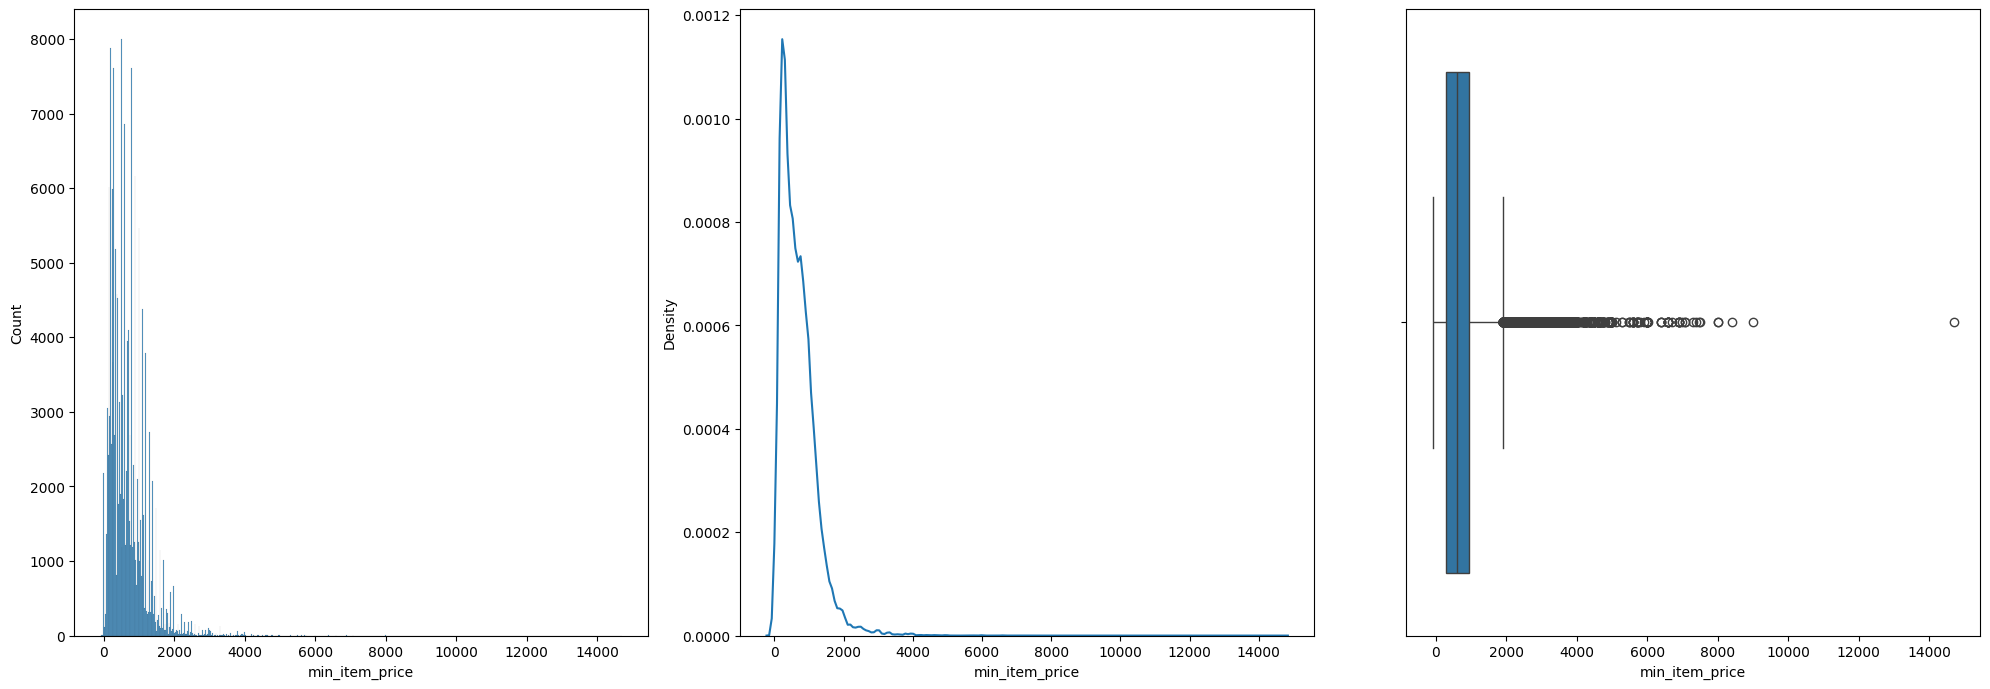

In [93]:
continue_plot(data, 'min_item_price')

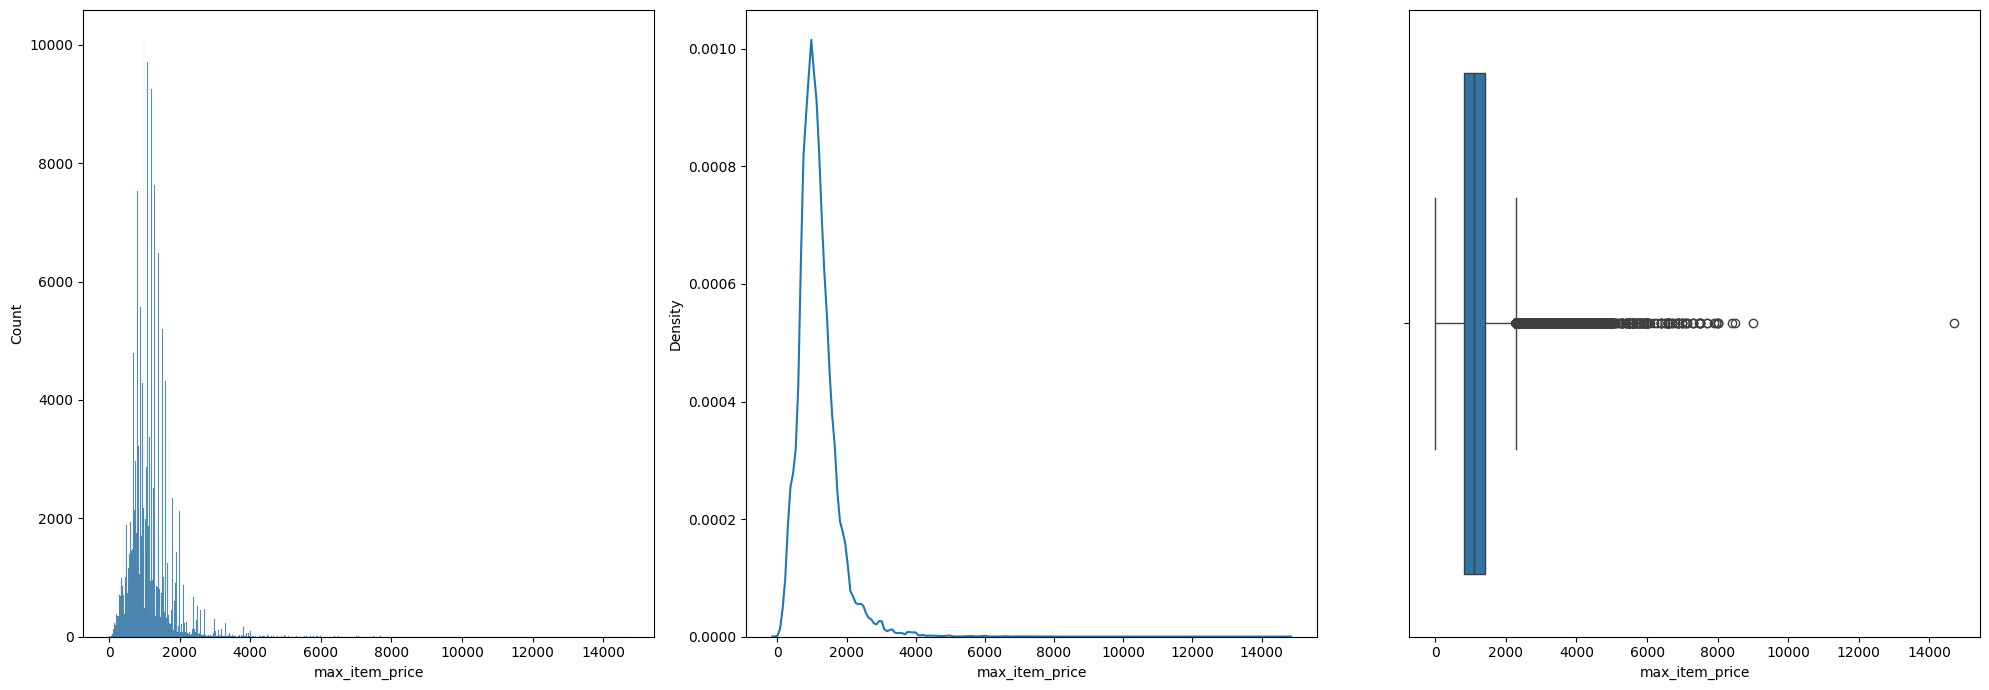

In [94]:
continue_plot(data, 'max_item_price')

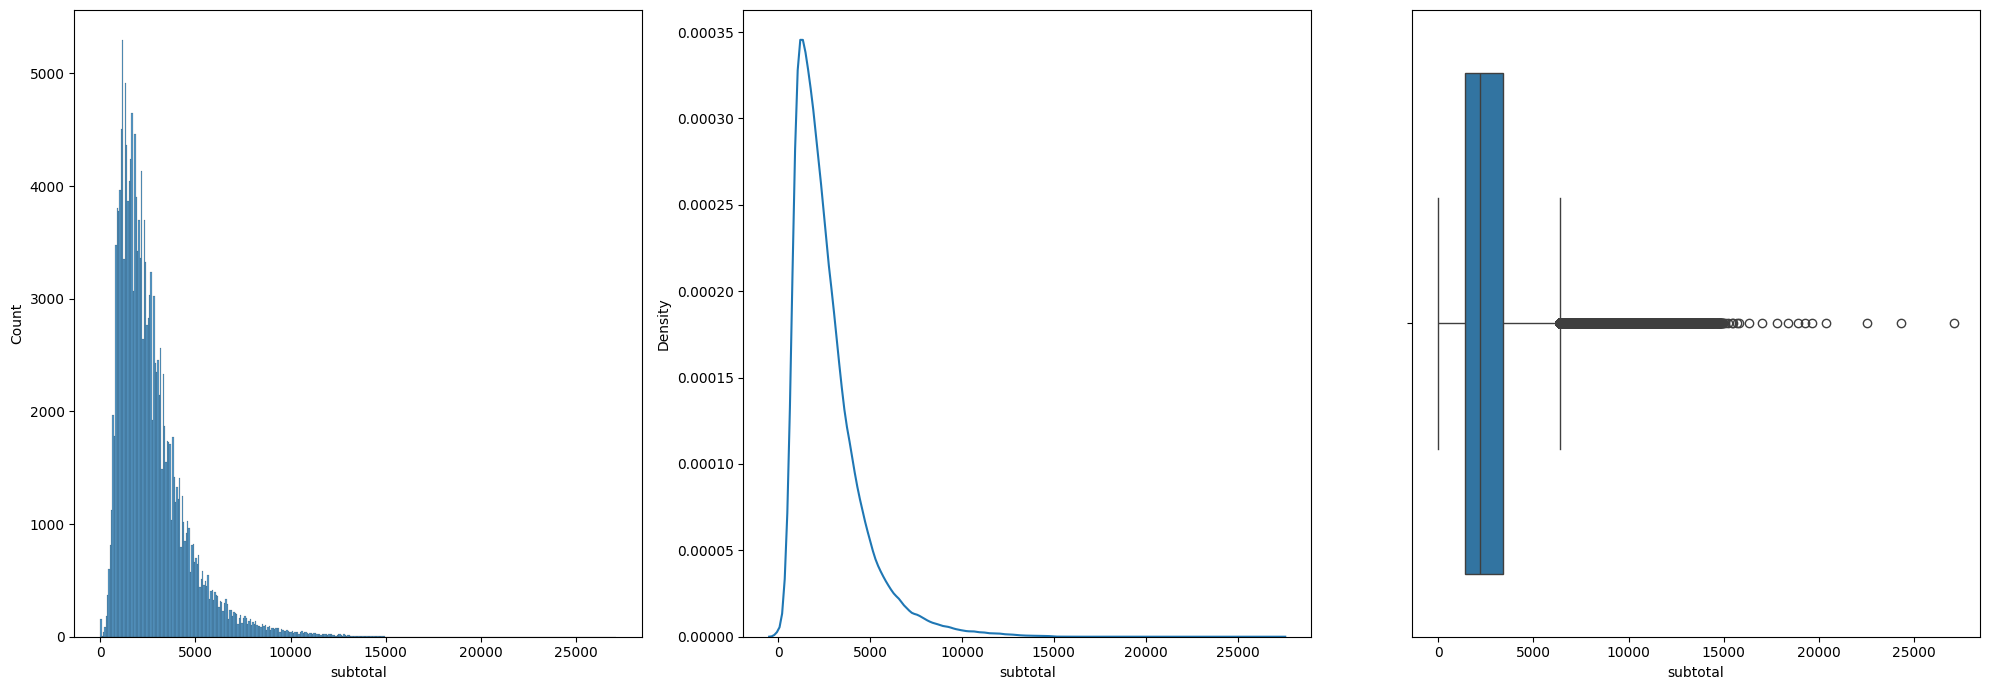

In [95]:
continue_plot(data, 'subtotal')

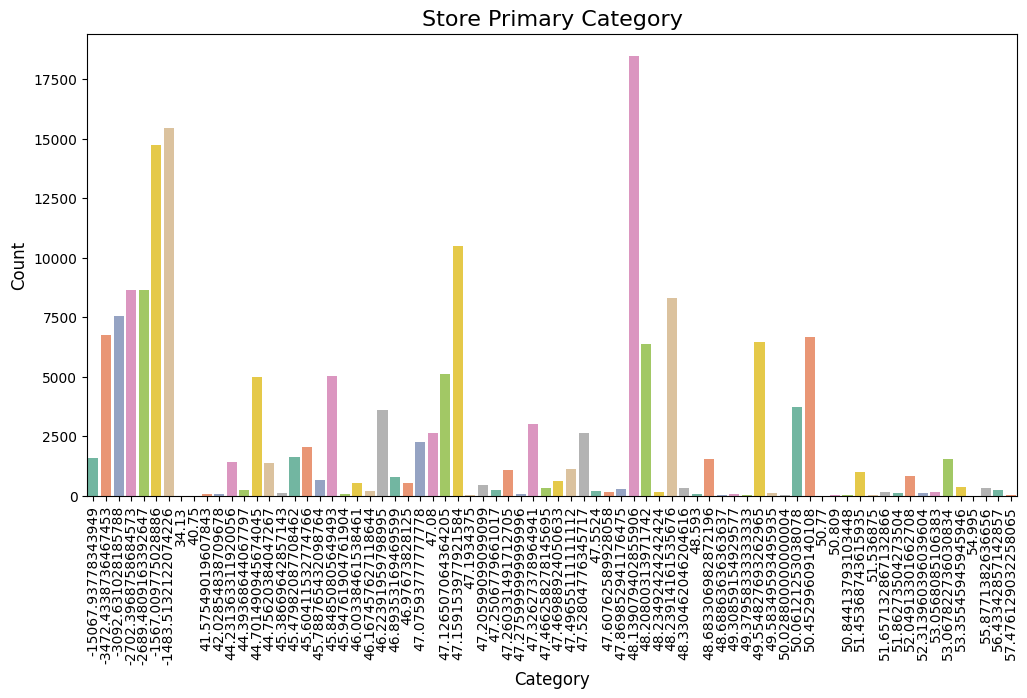

In [96]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=data, x="store_primary_category", ax=ax, palette="Set2")

ax.set_title("Store Primary Category", fontsize=16)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.show()

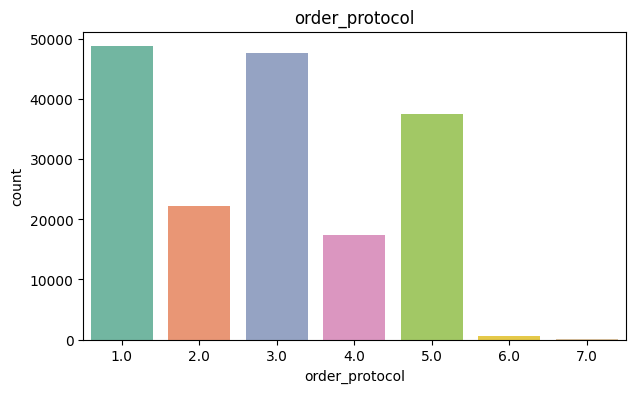

In [97]:
fig,ax = plt.subplots(figsize=(7,4))
sns.countplot(data, x= "order_protocol",ax=ax,palette="Set2")
ax.set_title("order_protocol")
plt.show()

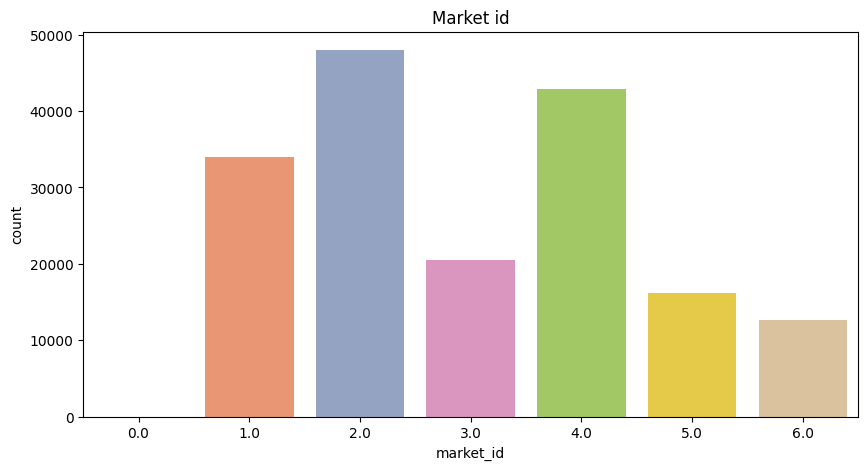

In [98]:
fig,ax = plt.subplots(figsize=(10,5))
sns.countplot(data, x="market_id",ax=ax,palette="Set2")
ax.set_title("Market id")
plt.show()

#### Bivariate Analysis

In [99]:
store_category = data.groupby('store_primary_category')['subtotal'].sum().to_frame().reset_index()
store_category = store_category.sort_values('subtotal',ascending=False)
store_category = store_category.head(10)
store_category = store_category.reset_index(drop=True)
store_category

,store_primary_category,subtotal
0,48.139079,49755438
1,-1483.513212,46774163
2,-1567.009775,33563454
3,-2689.480916,28965495
4,50.452996,25126333
5,48.239142,23616511
6,47.159154,23389720
7,48.208003,19693135
8,49.554828,18638280
9,-2702.396876,18257854


In [100]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
market_id,174258.0,2.985785,1.525868,0.000000e+00,2.000000,3.000000,4.000000,6.000000
store_primary_category,174258.0,-905.250567,1797.978888,-1.506794e+04,-1567.009775,47.075938,48.139079,57.476129
order_protocol,174258.0,2.854268,1.490139,1.000000e+00,1.000000,3.000000,4.000000,7.000000
total_items,174258.0,3.200129,2.664916,1.000000e+00,2.000000,3.000000,4.000000,411.000000
subtotal,174258.0,2683.631139,1825.373725,0.000000e+00,1400.000000,2200.000000,3396.000000,27100.000000
num_distinct_items,174258.0,2.676881,1.634014,1.000000e+00,1.000000,2.000000,3.000000,20.000000
min_item_price,174258.0,684.052388,519.319530,-8.600000e+01,299.000000,595.000000,942.000000,14700.000000
max_item_price,174258.0,1158.142559,559.098782,0.000000e+00,799.000000,1095.000000,1395.000000,14700.000000
total_onshift_partners,174258.0,41.207296,35.316681,-3.000000e+00,13.000000,32.000000,62.000000,171.000000
total_busy_partners,174258.0,38.401135,32.913704,-5.000000e+00,11.000000,30.000000,60.000000,154.000000


<Axes: >

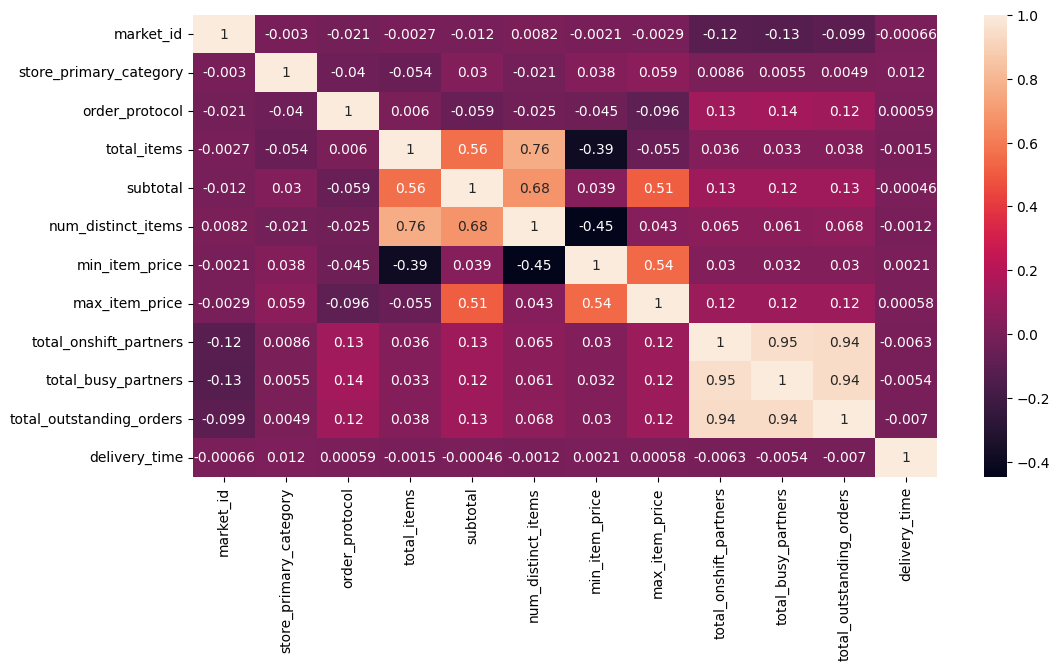

In [101]:
plt.subplots(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True)


#### Check outliers

<Axes: xlabel='delivery_time', ylabel='subtotal'>

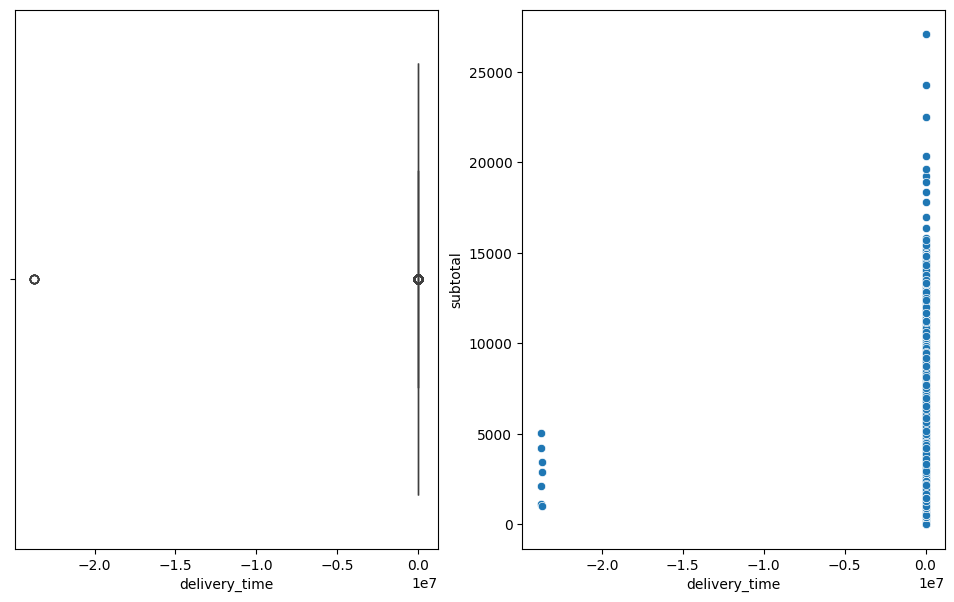

In [102]:
fig, axs = plt.subplots(1,2, figsize = (12,7))
sns.boxplot(x=data["delivery_time"], data = data,ax=axs[0])
sns.scatterplot(x='delivery_time',y='subtotal',data=data,ax=axs[1])

#### Inference
* There are outliers present in the dataset.
* Removing outliers by interquartile method

In [103]:
Q3 = data['delivery_time'].quantile(0.75)
Q1 = data['delivery_time'].quantile(0.25)
IQR = Q3-Q1
data = data[(data['delivery_time'] > Q1 - 1.5*IQR) & (data['delivery_time'] < Q3 + 1.5*IQR)]

<Axes: xlabel='delivery_time', ylabel='subtotal'>

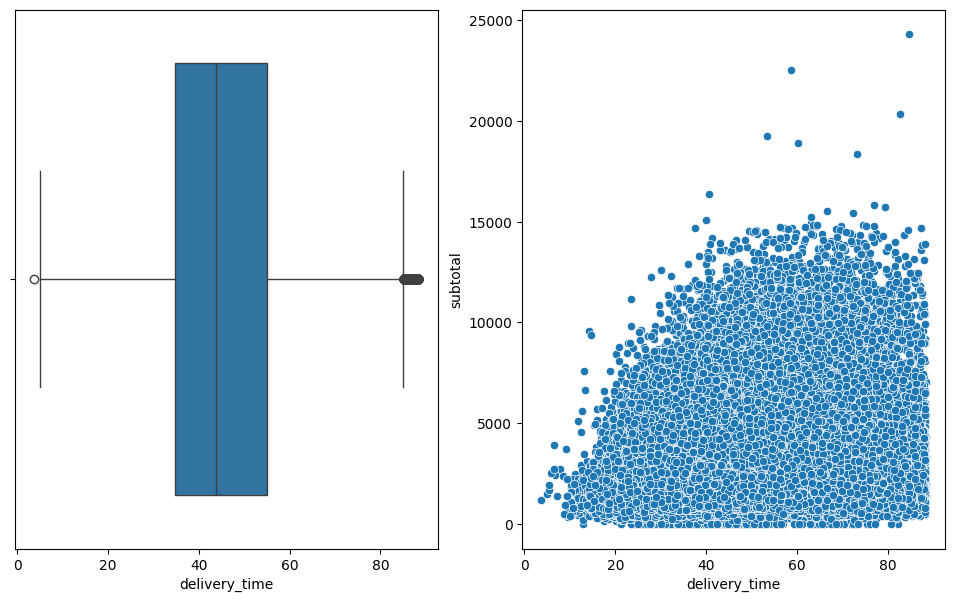

In [104]:
#Plotting the data again to see if anything has improved

fig, axs = plt.subplots(1,2, figsize = (12,7))
sns.boxplot(x=data["delivery_time"], data = data,ax=axs[0])
sns.scatterplot(x='delivery_time',y='subtotal',data=data,ax=axs[1])

after removing outliers our data is looking better

#### Scaling the data for neural networks

In [105]:
X = data.drop(columns = ["delivery_time"], axis = 1)
y = data["delivery_time"]

In [106]:
# Split the data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling separately to training and test sets
scaler = MinMaxScaler()

# Fit only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Creating a simple neural network

In [107]:
model = Sequential([
    Dense(64, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1],)),
    Dense(516, activation='relu'),
    Dense(1024,activation='relu'),
    Dense(256,activation='relu'),
    Dense(1,activation='linear')
])

### Training the neural network for required amount of epochs (Hyperparameter tuning)

In [108]:
adam=Adam(learning_rate=0.01)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])

##Training the neural network for required amount of epochs
history=model.fit(X_train,y_train,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - loss: 900064.8750 - mae: 151.1386 - mse: 900064.8750 - val_loss: 219.4472 - val_mae: 11.6006 - val_mse: 219.4472
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 213.5972 - mae: 11.5707 - mse: 213.5972 - val_loss: 198.3783 - val_mae: 11.0819 - val_mse: 198.3783
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 198.8764 - mae: 11.1856 - mse: 198.8764 - val_loss: 206.8185 - val_mae: 11.8512 - val_mse: 206.8185
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 191.2175 - mae: 10.9818 - mse: 191.2175 - val_loss: 189.3942 - val_mae: 11.1954 - val_mse: 189.3942
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 187.7430 - mae: 10.8997 - mse: 187.7430 - val_loss: 181.0457 - val_mae: 10.7275 - val_mse: 181.0457
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - loss: 188.5751 - mae: 10.8968 - mse: 188.5751 - val_loss: 199.6165 - val_mae: 10.8425 - val_mse: 199.6165
Epoch 7/30
211/

### Plotting the losses and checking the accuracy of the model¶

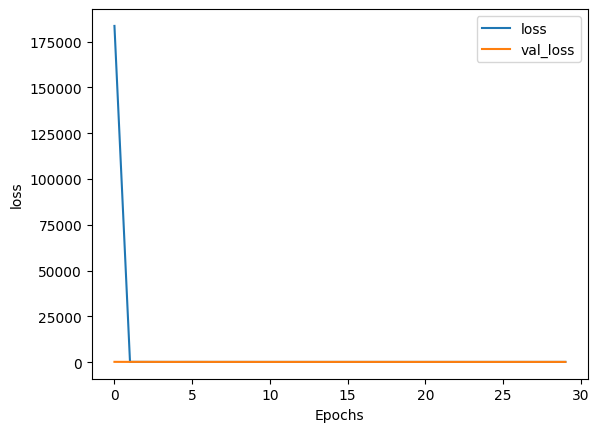

In [109]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()
#plot the history
plot_history(history,'loss')

#### Inference:
val loss is mostly below training loss so our model is not overfitting

In [110]:
z= model.predict(X_test)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [111]:
mse=mean_squared_error(y_test,z)
rmse=mse**.5
print("Mean Squared Error : ",mse)
print("Root Mean Squared Error : ",rmse)
mae=mean_absolute_error(y_test,z)
print("Mean Absolute Error : ",mae)
r2_score_RF = r2_score(y_test,z)
print("r2_score : ",r2_score_RF)

Mean Squared Error :  179.6500073239378
Root Mean Squared Error :  13.403358061468694
Mean Absolute Error :  10.553065706542196
r2_score :  0.17702330777059327


#### **Tune Neural network**

In [114]:
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))  # Dropout layer to reduce overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [115]:
# Compile the model
adam = Adam(learning_rate=0.005)
model.compile(optimizer=adam, loss='mse', metrics=['mse', 'mae'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 483.0878 - mae: 16.5094 - mse: 483.0878 - val_loss: 178.7429 - val_mae: 10.6966 - val_mse: 178.7429
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 198.6487 - mae: 11.1839 - mse: 198.6487 - val_loss: 177.4947 - val_mae: 10.5474 - val_mse: 177.4947
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 194.1407 - mae: 11.0330 - mse: 194.1407 - val_loss: 176.8831 - val_mae: 10.5265 - val_mse: 176.8831
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 192.1694 - mae: 10.9805 - mse: 192.1694 - val_loss: 177.1527 - val_mae: 10.5132 - val_mse: 177.1527
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 186.5988 - mae: 10.8522 - mse: 186.5988 - val_loss: 176.3383 - val_mae: 10.6379 - val_mse: 176.3383
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 185.6710 - mae: 10.8110 - mse: 185.6710 - val_loss: 178.8038 - val_mae: 10.8147 - val_mse: 178.8038
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [116]:
# Predict on test set
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error :", mse)
print("Root Mean Squared Error :", rmse)
print("Mean Absolute Error :", mae)
print("R2 Score :", r2)

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step
Mean Squared Error : 172.33225970127347
Root Mean Squared Error : 13.127538219379652
Mean Absolute Error : 10.412304742462023
R2 Score : 0.21054590998352096
